In [1]:
# Imports
import torch
import random
import torchvision
from torch import nn, reshape
import glob
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Module
from torch_lr_finder import LRFinder
from torch_lr_finder import TrainDataLoaderIter
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import BatchNorm2d, MaxUnpool2d, Sigmoid, Flatten, Unflatten
from torch.nn import ConvTranspose2d
import torchvision.transforms as transforms
from torch import flatten
from torchsummary import summary
from torch.utils.data import random_split
from torch.optim import Adam
import time
import torchvision.transforms.functional as T
from tqdm import tqdm
import keras
from torchsummary import summary

In [3]:
import glob
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt


image_folder = 'TrashDataset/new_x_/'
gt_folder = 'TrashDataset/new_y_/'
data = []
(x_img , y_img) = (100,100)
batch_size = 16

files = glob.glob(image_folder + "*")

for curr_img in files:

    pic_name = curr_img.split('\\')[-1]
    curr_gt = f'{gt_folder}{pic_name}'
    raw_img = cv2.imread(curr_img)
    raw_img = cv2.resize(raw_img, (x_img,y_img))


    mask_image = cv2.imread(curr_gt)
    #mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask_image = cv2.resize(mask_image, (x_img,y_img))
   
    data.append((raw_img,mask_image))

print(len(data))



print(data[33][1].shape)

5349
(100, 100, 3)


Text(0.5, 1.0, 'Image Mask')

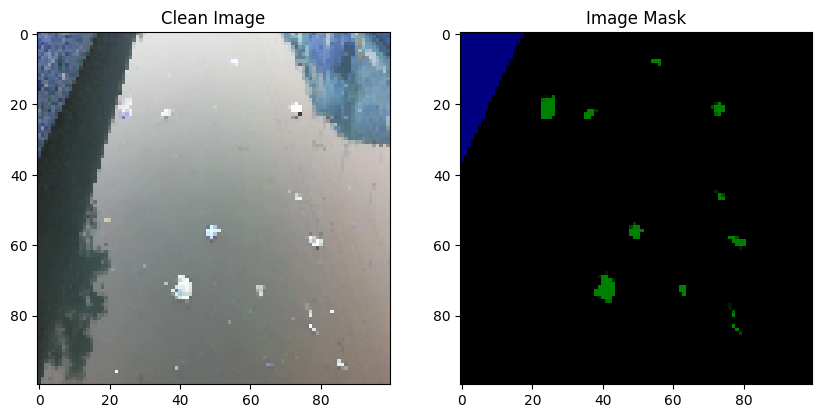

In [8]:
img = 22
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.array(data[img][0]))
axes[0].set_title('Clean Image')

# Plot the second image in the second subplot
axes[1].imshow(np.array(data[img][1]))
axes[1].set_title('Image Mask')



In [197]:
# Dataloaders

import glob
import torch
from torch.utils.data import random_split

from torch.utils.data import Dataset, DataLoader

class TrashDataset(Dataset):

    def __init__(self,data) -> None:
       
       self.data = data


    def __len__(self):

        return(len(self.data))

    def __getitem__(self, index):

        img = self.data[index][0]
        mask = self.data[index][0]
        img = torch.from_numpy(raw_img)
        img = img.type(torch.LongTensor)
        mask = torch.from_numpy(mask_image)
        mask = mask.type(torch.LongTensor)
        return (img.float(), mask.float())



dataset = TrashDataset(data)

numTrain = int(0.7 * (len(dataset)))
numTest = int(len(dataset) - numTrain)


(trainData, testData) = random_split(dataset, [numTrain,numTest] ,generator=torch.Generator().manual_seed(42))

trainLoader = DataLoader(trainData, batch_size=batch_size,drop_last=True)
testLoader = DataLoader(testData, batch_size=batch_size,drop_last=True)


In [198]:
#### Model

class depthwise_point(Module):

    def __init__(self, in_chan, out_chan) -> None:
        super(depthwise_point, self).__init__()

        self.div = min(in_chan,128)
        self.conv = nn.Sequential(

            Conv2d(in_channels=in_chan, out_channels=in_chan, kernel_size=3, padding=1, stride=1, groups=in_chan),
            Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=1, padding=0, groups=1)
        )

    def forward(self,x):

        return self.conv(x)

class EncodeForward(nn.Module):

    def __init__(self, in_chan, out_chan) -> None:
        super(EncodeForward, self).__init__()

       

        self.conv = nn.Sequential(

            depthwise_point(in_chan,out_chan),
            BatchNorm2d(out_chan),
            ReLU(inplace=True),
            depthwise_point(out_chan,out_chan),
            BatchNorm2d(out_chan),
            ReLU(inplace=True),

        )

    def forward(self,x):

        return self.conv(x)


class EncodeDown(nn.Module):

    def __init__(self, in_chan, out_chan) -> None:
        super(EncodeDown, self).__init__()

        self.conv = nn.Sequential(
            MaxPool2d(2,2),
            EncodeForward(in_chan, out_chan)
        )

    def forward(self,x):

        return self.conv(x)
    


class DecodeUp(nn.Module):

    def __init__(self, in_chan, out_chan) -> None:
        super().__init__()

        #go two forward then transpose

        self.conv = nn.Sequential(
            
            depthwise_point(in_chan,in_chan),
            BatchNorm2d(in_chan),
            ReLU(inplace=True),

            torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            EncodeForward(in_chan,out_chan),
            #ConvTranspose2d(in_chan, out_chan,2,2),
            BatchNorm2d(out_chan),
            ReLU(inplace=True),
        )

    def forward(self,x):

        return self.conv(x)




class TrashCNN(Module):

    def __init__(self) -> None:
        super(TrashCNN, self).__init__()


        self.e1 = EncodeForward(3,64)
        self.e2 = EncodeDown(64,128)
        self.e3 = EncodeDown(128,256)
        self.e4 = EncodeDown(256,512)
        self.e5 = EncodeDown(512,1024)
        
        self.u1 = DecodeUp(1024,512)
        self.u2 = DecodeUp(1024,256)
        self.u3 = DecodeUp(512,128)
        self.u4 = DecodeUp(256,64)
        self.u5 = EncodeForward(128,3)

        #self.transpose = ConvTranspose2d(1024,512,2,2)
        self.transpose = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.transForward = EncodeForward(1024,512)

    
    def forward(self,x):
        
        # These are skip connections + encoding
        o_e1 = self.e1(x)
        o_e2 = self.e2(o_e1)
        o_e3 = self.e3(o_e2)
        o_e4 = self.e4(o_e3)
        o_e5 = self.e5(o_e4)

        o_u1 = self.transpose(o_e5)
        o_u1 = self.transForward(o_u1)


        o_u1 = T.resize(o_u1, o_e4.shape[2:])
        o_u1 = torch.cat([o_e4, o_u1], dim=1)

        o_u2 = self.u2(o_u1)
        o_u2  = T.resize(o_u2, o_e3.shape[2:])
        o_u2 = torch.cat([o_e3, o_u2], dim=1)


        o_u3 = self.u3(o_u2)
        o_u3 = torch.cat([o_e2, o_u3], dim=1)
        
        o_u4 = self.u4(o_u3)
        o_u4 = torch.cat([o_e1, o_u4], dim=1)

        o_u5 = self.u5(o_u4)

        return o_u5
        #return [(o_e1, o_e2, o_e3, o_e4, o_e5), ( o_u1, o_u2,o_u3,o_u4, o_u5)]

In [199]:
## Test 1 Sample + Parameter Count

model = TrashCNN()
model = model.to('cuda')


summary(model, (3,512,512))

# x = torch.randn(1,3,512,512)
# x = x.to('cuda')

# pred = model(x)

# #print(pred.shape)

# for i in range(len(pred[0])):
#     print(f' {i + 1} : {pred[0][i].shape}')

# print("")

# for i in range(len(pred[1])):
#     print(f' {i + 1} : {pred[1][i].shape}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 512, 512]              30
            Conv2d-2         [-1, 64, 512, 512]             256
   depthwise_point-3         [-1, 64, 512, 512]               0
       BatchNorm2d-4         [-1, 64, 512, 512]             128
              ReLU-5         [-1, 64, 512, 512]               0
            Conv2d-6         [-1, 64, 512, 512]             640
            Conv2d-7         [-1, 64, 512, 512]           4,160
   depthwise_point-8         [-1, 64, 512, 512]               0
       BatchNorm2d-9         [-1, 64, 512, 512]             128
             ReLU-10         [-1, 64, 512, 512]               0
    EncodeForward-11         [-1, 64, 512, 512]               0
        MaxPool2d-12         [-1, 64, 256, 256]               0
           Conv2d-13         [-1, 64, 256, 256]             640
           Conv2d-14        [-1, 128, 2

In [201]:
### Params

class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()

    def	forward(self, pred, target):
        
        i = 2. * (pred*target).sum() 
        u = (pred+target).sum()
        loss = 1 - ((i/u ) / pred.shape[0])
        
        return loss
        

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = TrashCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 0.00019)
lossFN = DiceLoss()
epochs = 4




def get_acc(preds, y):
    
    #preds = (preds > 0.5).float()
    num_correct = (preds == y).sum()
    num_pixels = torch.numel(preds)

    return num_correct/num_pixels


cuda


In [202]:
# Training


for epoch in range(epochs):

    model.train()
    
    train_loss = 0
    
    loop = tqdm(enumerate(trainLoader), total=len(trainLoader))
    for batch_i, (img, mask) in loop:

        img = img.to(device)
        mask = mask.to(device)



        #print(img.shape)
        with torch.cuda.amp.autocast():

            img = img.view(batch_size,3,x_img,y_img)
            mask = mask.view(batch_size,3,x_img,y_img)
            pred = model(img)
            
            
            loss = lossFN(pred,mask)
            acc = get_acc(pred,mask)
            #print(f'Loss : {loss}')
            
            train_loss += loss
            opt.zero_grad()
            loss.backward()
            opt.step()

            loop.set_description(f'Epoch {epoch}/{epochs}')
            loop.set_postfix(loss = loss.item(), acc = acc.item() )
        

    print('Epoch: %03d/%03d | Loss: %.4f'
                      % (epoch, epochs,train_loss))




Epoch 0/4:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch 0/4: 100%|██████████| 234/234 [00:53<00:00,  4.37it/s, acc=0.714, loss=0.26] 


Epoch: 000/004 | Loss: 101.3862


Epoch 1/4: 100%|██████████| 234/234 [00:53<00:00,  4.36it/s, acc=0.752, loss=0.182]


Epoch: 001/004 | Loss: 51.0308


Epoch 2/4: 100%|██████████| 234/234 [00:53<00:00,  4.34it/s, acc=0.824, loss=0.124]


Epoch: 002/004 | Loss: 35.3607


Epoch 3/4: 100%|██████████| 234/234 [00:54<00:00,  4.33it/s, acc=0.815, loss=0.0766]

Epoch: 003/004 | Loss: 23.3732


In [203]:
# Testing

num_correct = 0
num_pixels = 0

model.eval()

loss2 = DiceLoss()

with torch.no_grad():

    dice_Scores = []

    for (x,y) in testLoader:
        
        x = x.to('cuda')
        y = y.to('cuda')

        x = x.view(batch_size,3,x_img,y_img)
        y = y.view(batch_size,3,x_img,y_img)

        preds = model(x)
        dice = dice_Scores.append(1 - loss2(preds,y).cpu())

        
        preds = (preds > 0.5).float()
        num_correct += (preds == y).sum()
        num_pixels += torch.numel(preds)
        

print(f'Accuracy {num_correct/num_pixels}')
print(f'Dice Score {np.mean(np.array(dice_Scores))}')


Accuracy 0.9807000160217285
Dice Score 0.927773118019104
